# Курсовой проект для курса "Библиотеки Python для Data Science"

Задание: Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

Датасет: train.csv, test.csv.

Целевая переменная: Price.

Основная метрика: R2 - коэффициент детерминации.

Вспомогательная метрика: MSE - средняя квадратичная ошибка.

Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

## Load Packages

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score as r2
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

**Datasets path**

In [2]:
TRAIN_DATASET_PATH = 'Datasets/train.csv'
TEST_DATASET_PATH = 'Datasets/test.csv'

**Вспомогательная функция для подсчёта метрик**

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

## Load Data

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

In [5]:
train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855


In [6]:
test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

**В тренировочном датасете все столбцы имеют по 10000 значений, кроме:**
* LifeSquare - 7887
* Healthcare_1 - 5202

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

**В тестовом датасете все столбцы имеют по 5000 значений, кроме:**
* LifeSquare - 3959
* Healthcare_1 - 2623

## Memory optimization

In [9]:
def reduce_memory_usage(df):
    
    start_memory = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_memory))
    
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_memory))
    print('Decreased by {:.1f}%'.format(100 * (start_memory - end_memory) / start_memory))
    
    return df

In [10]:
train = reduce_memory_usage(train)
test = reduce_memory_usage(test)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.47 MB
Decreased by 69.4%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 71.7%


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  uint16  
 1   DistrictId     10000 non-null  uint8   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   uint16  
 1   DistrictId     5000 non-null   uint8   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   uint8   
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   uint16  
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   uint8   
 13  Social_2       5000 non-null   uint16  
 14  Social_3       5000 non-null   uint8   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   uint8   
 17  Shops_1        5000 non-null   ui

Выделим категориальные и числовые признаки, на основании типов данных:

In [13]:
categorical = [i for i in train.columns if train[i].dtype.name == 'category']
numerical   = [i for i in train.columns if train[i].dtype.name != 'category']
print("Категориальные признаки:\n{}".format(categorical))
print("Числовые признаки:\n{}".format(numerical))

Категориальные признаки:
['Ecology_2', 'Ecology_3', 'Shops_2']
Числовые признаки:
['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price']


Обзор категориальных признаков:

In [14]:
train[categorical].describe()

,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000
unique,2,2,2
top,B,B,B
freq,9903,9725,9175


Значения категориальных признаков:

In [15]:
for i in categorical:
    print(train[i].unique())

[B, A]
Categories (2, object): [B, A]
[B, A]
Categories (2, object): [B, A]
[B, A]
Categories (2, object): [B, A]


Обзор числовых признаков:

In [16]:
train[numerical].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839522,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315720,21.058716,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,7887.0,37.199665,86.241219,0.370619,22.769833,32.781261,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560839,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.776200,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218670e-01


Признаки 'Id' и 'DistrictId' не играют роли

In [17]:
train = train.drop(['Id', 'DistrictId'], axis=1, inplace=False)

**Целевая переменная**

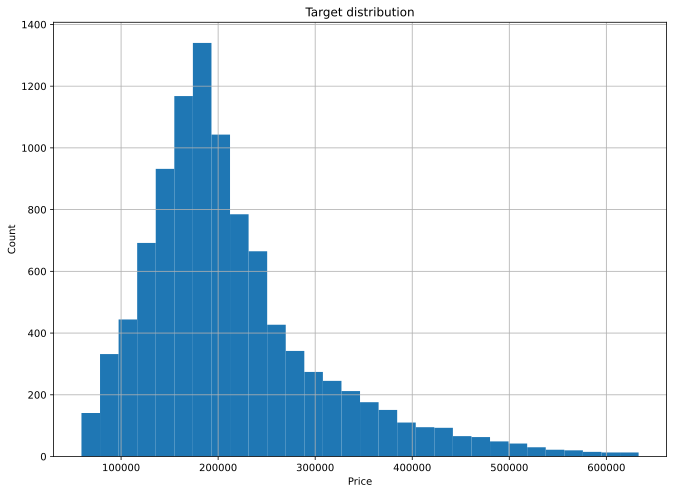

In [18]:
plt.figure(figsize = (11, 8))

train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

## Data preparation

**Заполнение пропущенных значений**

Признак LifeSquare, Healthcare_1 имеют пропущенные значения, поэтому:
* LifeSquare - заполним средним
* Healthcare_1 - удалим признак

In [19]:
train_outliers = train.copy()

In [20]:
LifeSquare_mean = train_outliers["LifeSquare"].mean()
train_outliers = train_outliers.drop(['Healthcare_1'], axis=1, inplace=False)

train_outliers["LifeSquare"].fillna(LifeSquare_mean, inplace=True)

print(f"Среднее признака LifeSquare: {LifeSquare_mean}\n")
print(train_outliers.info())

Среднее признака LifeSquare: 37.19966506958008

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Rooms          10000 non-null  float32 
 1   Square         10000 non-null  float32 
 2   LifeSquare     10000 non-null  float32 
 3   KitchenSquare  10000 non-null  float32 
 4   Floor          10000 non-null  uint8   
 5   HouseFloor     10000 non-null  float32 
 6   HouseYear      10000 non-null  uint32  
 7   Ecology_1      10000 non-null  float32 
 8   Ecology_2      10000 non-null  category
 9   Ecology_3      10000 non-null  category
 10  Social_1       10000 non-null  uint8   
 11  Social_2       10000 non-null  uint16  
 12  Social_3       10000 non-null  uint8   
 13  Helthcare_2    10000 non-null  uint8   
 14  Shops_1        10000 non-null  uint8   
 15  Shops_2        10000 non-null  category
 16  Price          10000 non-null

Обработка выбросов признака **'Rooms'**

In [21]:
train_outliers['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [22]:
train_outliers.loc[train_outliers['Rooms'].isin([0, 6, 10, 19]), 'Rooms'] = train_outliers['Rooms'].median()

In [23]:
train_outliers['Rooms'].value_counts()

2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

Обработка выбросов признаков **'LifeSquare', 'KitchenSquare'**

In [24]:
train_outliers['KitchenSquare'].quantile(.975), train_outliers['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [25]:
condition = (train_outliers['KitchenSquare'].isna()) \
             | (train_outliers['KitchenSquare'] > train_outliers['KitchenSquare'].quantile(.975))
        
train_outliers.loc[condition, 'KitchenSquare'] = train_outliers['KitchenSquare'].median()

train_outliers.loc[train['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [26]:
train_outliers['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

Обработка выбросов признака **'HouseFloor'**

In [27]:
train_outliers['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [28]:
train_outliers['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=uint8)

In [29]:
(train_outliers['Floor'] > train_outliers['HouseFloor']).sum()

1825

In [30]:
train_outliers.loc[train_outliers['HouseFloor'] == 0, 'HouseFloor'] = train_outliers['HouseFloor'].median()
floor_outliers = train_outliers[train_outliers['Floor'] > train_outliers['HouseFloor']].index

train_outliers.loc[floor_outliers, 'Floor'] = train_outliers.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

Обработка выбросов признака **'HouseYear'**

In [31]:
train_outliers.loc[train_outliers['HouseYear'] > 2020, 'HouseYear'] = 2020

In [32]:
train_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Rooms          10000 non-null  float32 
 1   Square         10000 non-null  float32 
 2   LifeSquare     10000 non-null  float32 
 3   KitchenSquare  10000 non-null  float32 
 4   Floor          10000 non-null  int64   
 5   HouseFloor     10000 non-null  float32 
 6   HouseYear      10000 non-null  uint32  
 7   Ecology_1      10000 non-null  float32 
 8   Ecology_2      10000 non-null  category
 9   Ecology_3      10000 non-null  category
 10  Social_1       10000 non-null  uint8   
 11  Social_2       10000 non-null  uint16  
 12  Social_3       10000 non-null  uint8   
 13  Helthcare_2    10000 non-null  uint8   
 14  Shops_1        10000 non-null  uint8   
 15  Shops_2        10000 non-null  category
 16  Price          10000 non-null  float32 
dtypes: category(3), float32(7), int6

Обработка категориальных признаков **'Ecology_2', 'Ecology_3', 'Shops_2'**

In [33]:
print(f"Значения признака Ecology_2:\n{train['Ecology_2'].value_counts()}\n")
print(f"Значения признака Ecology_3:\n{train['Ecology_3'].value_counts()}\n")
print(f"Значения признака Shops_2:\n{train['Shops_2'].value_counts()}\n")

Значения признака Ecology_2:
B    9903
A      97
Name: Ecology_2, dtype: int64

Значения признака Ecology_3:
B    9725
A     275
Name: Ecology_3, dtype: int64

Значения признака Shops_2:
B    9175
A     825
Name: Shops_2, dtype: int64



Преобразуем данные признаки в цифровые значения для дальнейшего анализа.

In [34]:
binary_to_numbers =  { 'A': 0,
                      'B': 1,}

train_outliers['Ecology_2'] = train_outliers['Ecology_2'].map(binary_to_numbers)
train_outliers['Ecology_3'] = train_outliers['Ecology_3'].map(binary_to_numbers)
train_outliers['Shops_2'] = train_outliers['Shops_2'].map(binary_to_numbers)

print(f"Уникальные значения признака Ecology_2:\n{train_outliers['Ecology_2'].unique()}\n")
print(f"Уникальные значения признака Ecology_3:\n{train_outliers['Ecology_3'].unique()}\n")
print(f"Уникальные значения признака Shops_2:\n{train_outliers['Shops_2'].unique()}\n")

Уникальные значения признака Ecology_2:
[1, 0]
Categories (2, int64): [1, 0]

Уникальные значения признака Ecology_3:
[1, 0]
Categories (2, int64): [1, 0]

Уникальные значения признака Shops_2:
[1, 0]
Categories (2, int64): [1, 0]



**Стандартизация числовых признаков**

In [35]:
scaler = QuantileTransformer(n_quantiles=20, random_state=42)

In [36]:
train_outliers.columns.tolist()

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [37]:
feature_names = ['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [38]:
feature_names.remove('Price')

In [39]:
target_data = train_outliers['Price']
train_for_scaling = scaler.fit_transform(train_outliers[feature_names].astype(float))
train_scaled = pd.DataFrame(train_for_scaling, columns=feature_names)

train_scaled.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
0,0.868421,0.950007,0.605263,0.868421,0.289474,0.333333,0.881579,0.521155,1.0,1.0,0.285714,0.315789,0.000000,0.000000,0.000000,1.0
1,0.000000,0.179998,0.208662,0.684211,0.552632,0.197368,0.118421,0.610499,1.0,1.0,0.631579,0.638935,0.394737,0.552632,0.000000,1.0
2,0.868421,0.868409,0.847413,0.868421,0.131579,0.763158,0.661654,0.279815,1.0,1.0,0.684211,0.494312,0.000000,0.842105,0.289474,1.0
3,0.000000,0.200632,0.605263,0.000000,0.736842,0.921053,0.421053,0.157895,1.0,1.0,0.052632,0.052632,0.000000,0.000000,0.289474,1.0
4,0.578947,0.718466,0.706112,0.789474,0.921053,0.605263,0.223684,0.878588,1.0,1.0,0.684211,0.842105,0.526316,0.000000,0.789474,1.0


**Разбиение выборки на тренировочную и тестовую**

In [40]:
X = train_scaled[feature_names]
y = target_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=45)

## Применение алгоритма машинного обучения  Gradient Boosting Regressor для предсказания значения целевой переменной Price

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42, n_estimators=322).fit(X_train, y_train)

In [42]:
y_pred_train = gbr.predict(X_train)
y_pred = gbr.predict(X_test)

Train R2:	0.824
Test R2:	0.742


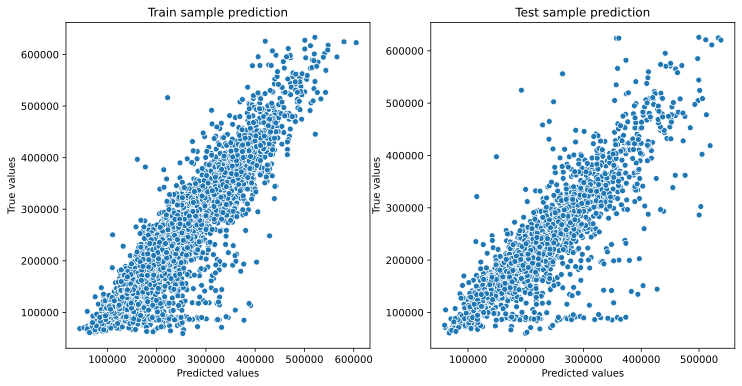

In [43]:
evaluate_preds(y_train, y_pred_train, y_test, y_pred)

In [44]:
cv_score = cross_val_score(gbr, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.76188307, 0.73188719, 0.72831332, 0.73359055, 0.75586504])

## Предсказание цен на тестовой выборке

In [45]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


Заполнение пропусков и векторизация в тестовой выборке

In [46]:
test_prep = test.copy()

In [47]:
LifeSquare_mean = test_prep["LifeSquare"].mean()
test_prep = test_prep.drop(['Healthcare_1'], axis=1, inplace=False)

test_prep["LifeSquare"].fillna(LifeSquare_mean, inplace=True)


print(f"Среднее признака LifeSquare:{LifeSquare_mean}\n")
print(test_prep.info())

Среднее признака LifeSquare:36.158756256103516

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   uint16  
 1   DistrictId     5000 non-null   uint8   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     5000 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   uint8   
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   uint16  
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   uint8   
 13  Social_2       5000 non-null   uint16  
 14  Social_3       5000 non-null   uint8   
 15  Helthcare_2    5000 non-null   uint8   
 16  Shops_1        5000 non-null  

In [48]:
binary_to_numbers =  { 'A': 0,
                      'B': 1,}

test_prep['Ecology_2'] = test_prep['Ecology_2'].map(binary_to_numbers)
test_prep['Ecology_3'] = test_prep['Ecology_3'].map(binary_to_numbers)
test_prep['Shops_2'] = test_prep['Shops_2'].map(binary_to_numbers)

print(f"Уникальные значения признака Ecology_2:\n{test_prep['Ecology_2'].unique()}\n")
print(f"Уникальные значения признака Ecology_3:\n{test_prep['Ecology_3'].unique()}\n")
print(f"Уникальные значения признака Shops_2:\n{test_prep['Shops_2'].unique()}\n")

Уникальные значения признака Ecology_2:
[1, 0]
Categories (2, int64): [1, 0]

Уникальные значения признака Ecology_3:
[1, 0]
Categories (2, int64): [1, 0]

Уникальные значения признака Shops_2:
[1, 0]
Categories (2, int64): [1, 0]



In [49]:
test_prep.keys()

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
       'Shops_1', 'Shops_2'],
      dtype='object')

In [50]:
feature_names = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
       'Shops_1', 'Shops_2']

In [51]:
test_for_scaling = scaler.fit_transform(test_prep.astype(float))

test_scaled = pd.DataFrame(test_for_scaling, columns=feature_names)

test_scaled.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
0,0.269244,0.526316,0.184211,0.098942,0.069237,0.368421,0.289474,0.315789,0.192982,0.310987,1.0,1.0,0.473684,0.399139,0.000000,0.526316,0.289474,1.0
1,0.351717,0.684211,0.184211,0.269345,0.762805,0.868421,0.473684,0.763158,0.960526,0.473684,1.0,1.0,0.105263,0.105263,0.368421,0.000000,0.000000,0.0
2,0.054998,0.368421,0.552632,0.614522,0.578947,0.763158,0.947368,0.863158,0.421053,0.765247,1.0,1.0,0.263158,0.263158,0.000000,0.000000,0.289474,1.0
3,0.227548,0.315789,0.868421,0.448205,0.424228,0.500000,0.052632,0.065789,0.105263,0.219649,1.0,1.0,0.105263,0.083057,0.000000,0.000000,0.000000,1.0
4,0.042735,0.736842,0.184211,0.515973,0.578947,0.184211,0.526316,0.763158,0.421053,0.898599,1.0,1.0,0.736842,0.786078,0.684211,0.000000,0.789474,1.0


**Подготовка выборки**

In [52]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
       'Shops_1', 'Shops_2']

In [53]:
X = test_scaled[feature_names]

In [54]:
submit = pd.read_csv('Datasets/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [55]:
y_pred = gbr.predict(X)
y_pred

array([161080.82449143, 124801.67138731, 170849.95659971, ...,
       134960.21242222, 182352.67855784, 265209.43175736])

In [56]:
submit['Price'] = y_pred
submit.head()

,Id,Price
0,4567,161080.824491
1,5925,124801.671387
2,960,170849.956600
3,3848,119760.275385
4,746,211671.874370


In [57]:
submit.to_csv('gbr_submit.csv', sep=',', index=False)